In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Pre-process mutation data

### Import TRACERx 

In [2]:
data_dir = "/data/morrisq/huangf2/project/mutLLM/data/tracerx_snv_96.csv"
df = pd.read_csv(data_dir, index_col=0)
print(df.shape)
df.head()

(659339, 18)


,Unnamed: 0,CASE_ID,SAMPLE,CHR,POS,TRI_NT_CONTEXT,histology_3,histology_full,anatomical_site_label,original_anatomical_site_label,sample_type,DEPTH,COPY_NUMBER_A,COPY_NUMBER_B,ACF,PLOIDY,REF,VAR
0,0,CRUK0719,CRUK0719_BR_T1.R1,9,16434926,TCGA,Other,Large cell carcinoma,metachronousMet_BR_T1,metachronousMet_BR_T1.R1,metastasis,913,8,0,0.24,4.05,TCA,G
1,1,CRUK0719,CRUK0719_BR_T1.R2,9,16434926,TCGA,Other,Large cell carcinoma,metachronousMet_BR_T1,metachronousMet_BR_T1.R2,metastasis,1006,9,0,0.53,4.05,TCA,G
2,2,CRUK0719,CRUK0719_SU_T1.R1,9,16434926,TCGA,Other,Large cell carcinoma,primary_SU_T1,primary_SU_T1.R1,primary,847,9,0,0.13,5.15,TCA,G
3,3,CRUK0719,CRUK0719_SU_T1.R2,9,16434926,TCGA,Other,Large cell carcinoma,primary_SU_T1,primary_SU_T1.R2,primary,801,8,0,0.11,4.40,TCA,G
4,4,CRUK0719,CRUK0719_SU_T1.R3,9,16434926,TCGA,Other,Large cell carcinoma,primary_SU_T1,primary_SU_T1.R3,primary,694,9,0,0.13,4.85,TCA,G


### Import IMPACT

In [3]:
impact_dir = '/data/morrisq/huangf2/project/mutLLM/data/impact_snv_augmented.csv'
df_impact = pd.read_csv(impact_dir, header=0)
print(df_impact.shape)
df_impact.head()

(2521939, 14)


,id,patient,tumor,chr,pos,mutation,ref,var,bias,strandedness,version,Sample Type,Cancer Type,Cancer Type Detailed
0,P-0000004-T01-IM3,4,1,1,16265904,TTAG,TTG,A,U,1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma
1,P-0000004-T01-IM3,4,1,1,16265908,ATAG,ATG,A,T,-1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma
2,P-0000004-T01-IM3,4,1,4,1801219,GCTG,GCG,T,U,1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma
3,P-0000004-T01-IM3,4,1,4,1801542,CTCA,CTA,C,T,-1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma
4,P-0000004-T01-IM3,4,1,4,1803704,ATCG,ATG,C,U,1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma


### Process position bins

In [4]:
bin_size = 5000000
df['CHR'] = df['CHR'].astype(int)
df['POS'] = df['POS'] // bin_size
chr_bins = round(df.groupby('CHR')['POS'].max()).to_list()

bins = {}
for i in range(1, 24):
    bins[i] = 0
for i in range(2, 24):
    bins[i] += bins[i-1] + int(chr_bins[i-2])
bins

{1: 0,
 2: 49,
 3: 97,
 4: 136,
 5: 174,
 6: 210,
 7: 244,
 8: 275,
 9: 304,
 10: 332,
 11: 359,
 12: 385,
 13: 411,
 14: 434,
 15: 455,
 16: 475,
 17: 493,
 18: 509,
 19: 524,
 20: 535,
 21: 547,
 22: 556,
 23: 566}

In [5]:
df['BIN'] = df['CHR'].map(bins) + df['POS']

In [6]:
df_impact['bin'] = df_impact['chr'].map(bins) + df_impact['pos'] // bin_size

### Impact NSCLC cohort

In [7]:
df_impact_nsclc = df_impact[df_impact['Cancer Type'] == 'Non-Small Cell Lung Cancer']
df_impact_nsclc.shape

(378334, 15)

# Construct tensor of mutations

In [8]:
sample_name = 'SAMPLE'
mutation_name = 'TRI_NT_CONTEXT'
bin_name = 'BIN'

unique_sample, counts_sample = np.unique(df[sample_name], return_counts=True)
unique_mut, counts_mut = np.unique(df[mutation_name], return_counts=True)
unique_bin, counts_bin = np.unique(df[bin_name], return_counts=True)

# build sample x mutation x bin tensor
tensor = np.zeros((len(unique_sample), len(unique_mut), len(unique_bin)))

In [9]:
map_sample = {sample: i for i, sample in enumerate(unique_sample)}
map_mut = {mut: i for i, mut in enumerate(unique_mut)}
map_bin = {bin: i for i, bin in enumerate(unique_bin)}

for i, row in df.iterrows():
    tensor[map_sample[row[sample_name]], map_mut[row[mutation_name]], map_bin[row[bin_name]]] += 1
    if i % 100000 == 0:
        print(i)

tensor.shape

0
100000
200000
300000
400000
500000
600000


(690, 96, 543)

In [10]:
sample_arr = np.array(list(map_sample.keys()))
mut_arr = np.array(list(map_mut.keys()))
bin_arr = np.array(list(map_bin.keys()))

# Tensor decomposition

In [11]:
from sklearn.decomposition import FactorAnalysis, PCA
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac, non_negative_parafac_hals

In [16]:
def plot_factors(factors, d=3):
    rank = factors[0].shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(16, int(rank * 2 + 1)))
    factors_name = ["Sample", "Tri-nucleotide context", "Position"] 
    factors_list = [sample_arr, mut_arr, bin_arr]
    for ind, (factor, axs) in enumerate(zip(factors[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            x = factors_list[ind]
            ax.bar(x, f)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    plt.xticks(rotation=90)
    fig.tight_layout()

nn_parafac_hals
- rank=5: 6m14s
- rank=10: 15min21s

In [14]:
X = tensor.copy()
rank = 2
factors_nnparafac_hals = non_negative_parafac_hals(X, rank=rank)

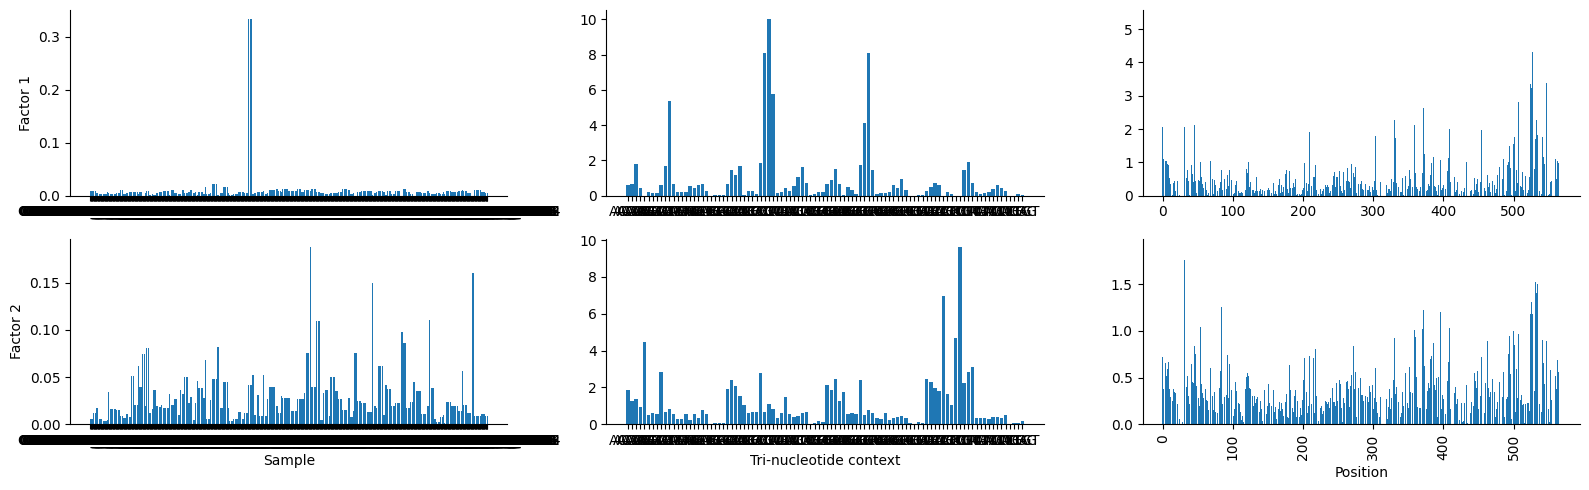

In [17]:
plot_factors(factors_nnparafac_hals.factors)

non_negative_parafac

In [52]:
X = tensor.copy()
rank = 10
factors_nnparafac = non_negative_parafac(X, rank=rank)

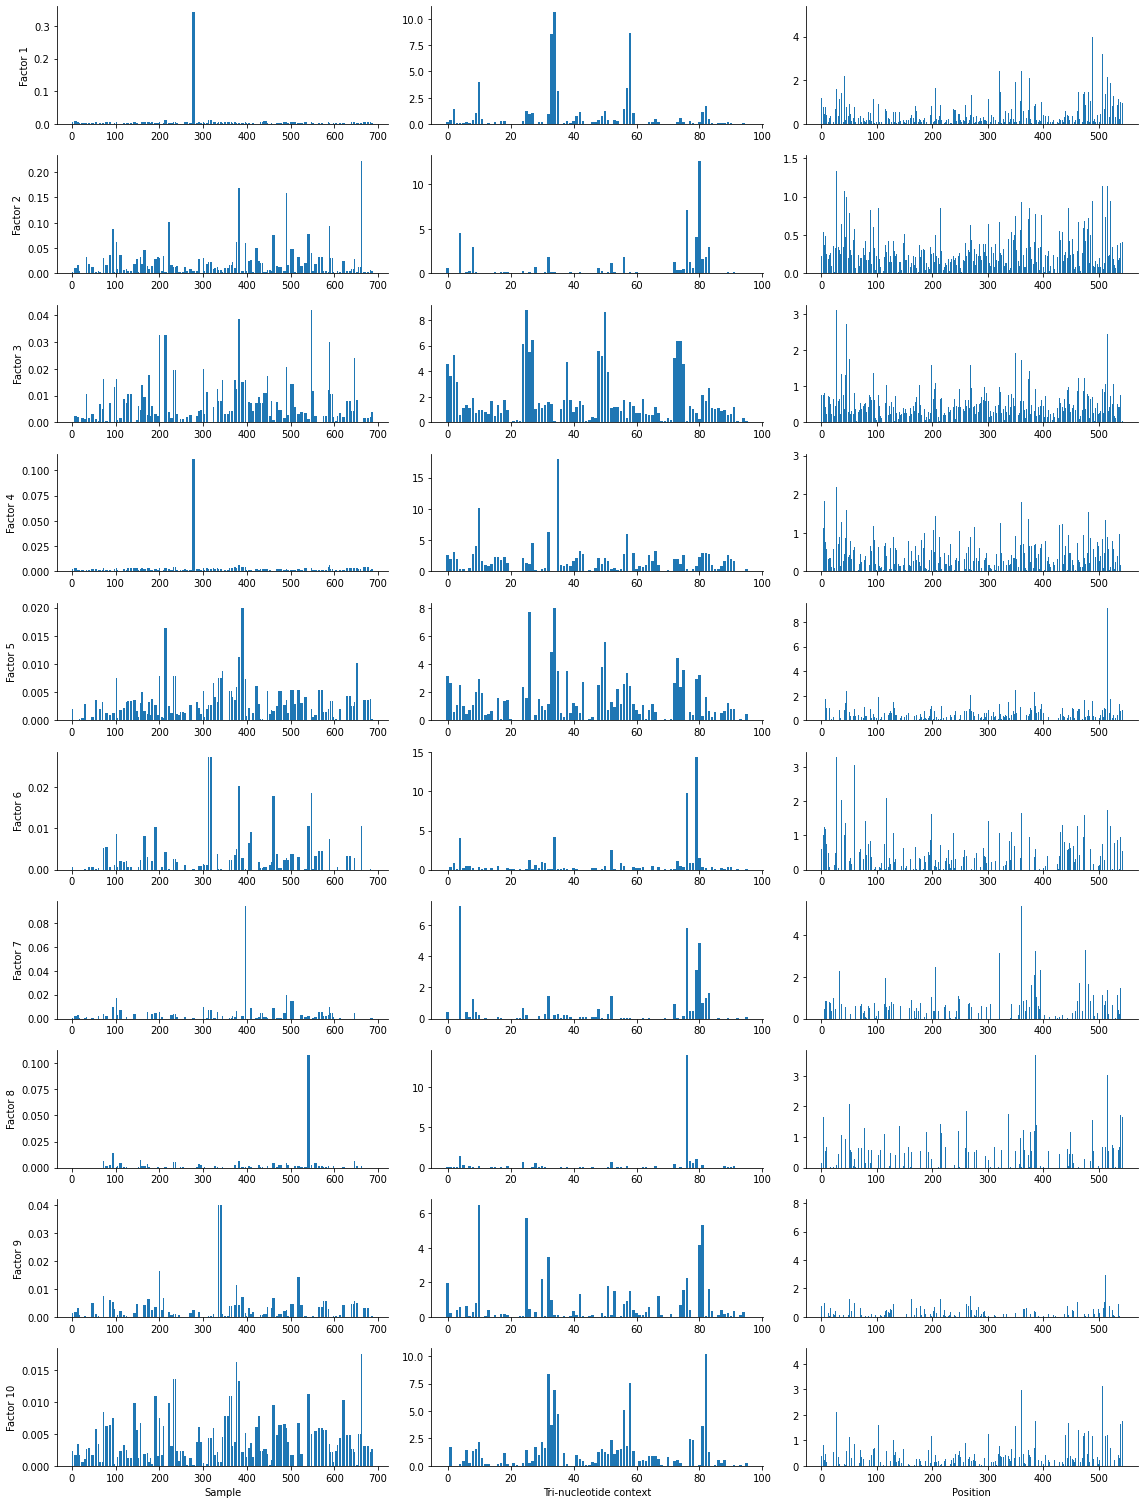

In [53]:
plot_factors(factors_nnparafac.factors)

HALs approximation leads to sparser factor loading across samples and tri-nucleotide contexts. Use default nn_parafac for now

# Fit tensor decomposition to IMPACT data

# Benchmark with SigProfiler

### Fitting COSMIC mutation signatures

In [2]:
from SigProfilerAssignment import Analyzer as Analyze

#### TRACERx

In [15]:
count_matrix = pd.crosstab(df['TRI_NT_CONTEXT'], df['SAMPLE'])

In [16]:
count_matrix.index = count_matrix.index.map(lambda x: re.sub(r'^(.{2})', r'\1>', x))
count_matrix

SAMPLE,CRUK0003_SU_FLN1,CRUK0003_SU_T1.R1,CRUK0003_SU_T1.R2,CRUK0003_SU_T1.R3,CRUK0003_SU_T1.R4,CRUK0003_SU_T1.R6,CRUK0004_BP_LN1,CRUK0004_SU_T1.R1,CRUK0004_SU_T1.R2,CRUK0004_SU_T1.R3,...,CRUK0817_SU_T1.R1,CRUK0817_SU_T1.R2,CRUK0817_SU_T1.R3,CRUK0817_SU_T1.R4,CRUK0817_SU_T1.R5,CRUK0872_SU_FLN1,CRUK0872_SU_T1.R1,CRUK0872_SU_T1.R2,CRUK0872_SU_T1.R3,CRUK0872_SU_T1.R4
TRI_NT_CONTEXT,,,,,,,,,,,,,,,,,,,,,
AC>AA,4,4,4,4,4,4,6,6,6,6,...,7,7,7,7,7,9,9,9,9,9
AC>AC,5,5,5,5,5,5,3,3,3,3,...,15,15,15,15,15,5,5,5,5,5
AC>AG,3,3,3,3,3,3,5,5,5,5,...,9,9,9,9,9,9,9,9,9,9
AC>AT,3,3,3,3,3,3,6,6,6,6,...,6,6,6,6,6,13,13,13,13,13
AC>GA,11,11,11,11,11,11,7,7,7,7,...,7,7,7,7,7,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TT>CT,7,7,7,7,7,7,5,5,5,5,...,5,5,5,5,5,7,7,7,7,7
TT>GA,0,0,0,0,0,0,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
TT>GC,1,1,1,1,1,1,0,0,0,0,...,3,3,3,3,3,0,0,0,0,0


In [17]:
Analyze.cosmic_fit(samples=count_matrix,
                   output="tracerx_mm",
                   input_type="matrix",
                   genome_build="GRCh37",
                   cosmic_version=3.3)

Assigning COSMIC sigs or Signature Database ...... 


|████████████████████████████████████████| 690/690 [100%] in 5:14.1 (2.20/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


#### MSK IMPACT

In [25]:
count_matrix_impact = pd.crosstab(df_impact_nsclc['mutation'], df_impact_nsclc['id'])
count_matrix_impact.index = count_matrix_impact.index.map(lambda x: re.sub(r'^(.{2})', r'\1>', x))

In [27]:
Analyze.cosmic_fit(samples=count_matrix_impact,
                   output="impact_nsclc_mm",
                   input_type="matrix",
                   genome_build="GRCh37",
                   cosmic_version=3.3)

Assigning COSMIC sigs or Signature Database ...... 


|████████████████████████████████████████| 9379/9379 [100%] in 49:53.9 (3.13/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


this took an hour...

### de novo extraction of signatures

Hi Feiayng,

i may not know how to code but at least I can write you a cute lil message:
You're doing amazing and i love you <3

Hehe code code code 
